# Twitter Sentiment Analysis

September, 2024.

### Importing the necessary libraries


In [ ]:
import nltk
import kagglehub
import pandas as pd
import re
import string
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Load the Dataset

Dictionary of Variables:

- ID: Unique identifier for each entry.
- Category: The category or entity associated with the tweet.
- Sentiment: The sentiment label (e.g., positive, negative, neutral).
- Text: The actual text of the tweet.

In [ ]:
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

100%|██████████| 1.99M/1.99M [00:00<00:00, 42.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2


In [ ]:
twitter_dataset = pd.read_csv('/root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2/twitter_training.csv')

In [ ]:
twitter_dataset.columns = ["ID", "Title", "Sentiment", "Text"]
twitter_dataset.head()

,ID,Title,Sentiment,Text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


### EDA

In [ ]:
twitter_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74681 non-null  int64 
 1   Title      74681 non-null  object
 2   Sentiment  74681 non-null  object
 3   Text       73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
sentiment_counts = twitter_dataset['Sentiment'].value_counts()
sentiment_counts

,count
Sentiment,
Negative,22542
Positive,20831
Neutral,18318
Irrelevant,12990


We see that there are 4 categories for the Sentiment column: Negative, Positive, Neutral and Irrelevant. Likewise, the class with the highest representation is Negative. There is not a very pronounced imbalance with the Positive and Neutral classes, but there is for the Irrelevant class.

In [ ]:
twitter_dataset.isnull().sum()

,0
ID,0
Title,0
Sentiment,0
Text,686


We can remove the null values from the dataset and work with the remaining information.

In [ ]:
twitter_dataset.dropna(inplace=True)

In [ ]:
twitter_dataset.isnull().sum()

,0
ID,0
Title,0
Sentiment,0
Text,0


### Coding the Target Variable

In [ ]:
encoder = LabelEncoder()
twitter_dataset['Sentiment'] = encoder.fit_transform(twitter_dataset['Sentiment'])
twitter_dataset.head()

,ID,Title,Sentiment,Text
0,2401,Borderlands,3,I am coming to the borders and I will kill you...
1,2401,Borderlands,3,im getting on borderlands and i will kill you ...
2,2401,Borderlands,3,im coming on borderlands and i will murder you...
3,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,3,im getting into borderlands and i can murder y...


In [ ]:
sentiment_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Sentiment Encoding Mapping:")
for category, code in sentiment_mapping.items():
    print(f"'{category}' corresponds to encoding: {code}")

Sentiment Encoding Mapping:
'Irrelevant' corresponds to encoding: 0
'Negative' corresponds to encoding: 1
'Neutral' corresponds to encoding: 2
'Positive' corresponds to encoding: 3


### Text Preprocessing

#### Text Removal

In NLP text processing, eliminating empty words is essential to improve the quality and efficiency of the analysis. These words, such as “the”, “is” and “and”, are common in texts but provide little semantic meaning. Removing them reduces noise in the data.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
def remove_stopwords(text):
    words = word_tokenize(text)  # Tokenizar el texto
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [ ]:
twitter_dataset['Text_processed'] = twitter_dataset['Text'].apply(remove_stopwords)
twitter_dataset.head()

,ID,Title,Sentiment,Text,Text_processed
0,2401,Borderlands,3,I am coming to the borders and I will kill you...,"coming borders kill ,"
1,2401,Borderlands,3,im getting on borderlands and i will kill you ...,"im getting borderlands kill ,"
2,2401,Borderlands,3,im coming on borderlands and i will murder you...,"im coming borderlands murder ,"
3,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,"im getting borderlands 2 murder ,"
4,2401,Borderlands,3,im getting into borderlands and i can murder y...,"im getting borderlands murder ,"


In text preprocessing for NLP, transforming all content to lowercase letters consists of unifying the formatting of words to ensure uniformity. This step makes it easier for algorithms to identify relationships and patterns by eliminating differences due to uppercase or lowercase letters. For example, words such as “The” and “the” are considered equivalent after this normalization.

In [ ]:
twitter_dataset['Text_processed'] = twitter_dataset['Text_processed'].str.lower()

In [ ]:
twitter_dataset.head()

,ID,Title,Sentiment,Text,Text_processed
0,2401,Borderlands,3,I am coming to the borders and I will kill you...,"coming borders kill ,"
1,2401,Borderlands,3,im getting on borderlands and i will kill you ...,"im getting borderlands kill ,"
2,2401,Borderlands,3,im coming on borderlands and i will murder you...,"im coming borderlands murder ,"
3,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,"im getting borderlands 2 murder ,"
4,2401,Borderlands,3,im getting into borderlands and i can murder y...,"im getting borderlands murder ,"


Removing HTML tags is a key step in NLP text preprocessing, as it allows you to focus only on the relevant textual content. These tags often include formatting information and metadata that do not add value to the linguistic analysis.

In [ ]:
def remove_html(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

In [ ]:
twitter_dataset['Text_processed'] = twitter_dataset['Text_processed'].apply(remove_html)

In [ ]:
twitter_dataset.head()

,ID,Title,Sentiment,Text,Text_processed
0,2401,Borderlands,3,I am coming to the borders and I will kill you...,"coming borders kill ,"
1,2401,Borderlands,3,im getting on borderlands and i will kill you ...,"im getting borderlands kill ,"
2,2401,Borderlands,3,im coming on borderlands and i will murder you...,"im coming borderlands murder ,"
3,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,"im getting borderlands 2 murder ,"
4,2401,Borderlands,3,im getting into borderlands and i can murder y...,"im getting borderlands murder ,"


Removing URLs is an important step to discard irrelevant information that does not add value to the linguistic analysis. These strings often contain website addresses, hyperlinks and other web-specific elements that can distort the analysis and generate confusion in machine learning models.

In [ ]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

In [ ]:
twitter_dataset['Text_processed'] = twitter_dataset['Text_processed'].apply(remove_url)

In [ ]:
twitter_dataset.head()

,ID,Title,Sentiment,Text,Text_processed
0,2401,Borderlands,3,I am coming to the borders and I will kill you...,"coming borders kill ,"
1,2401,Borderlands,3,im getting on borderlands and i will kill you ...,"im getting borderlands kill ,"
2,2401,Borderlands,3,im coming on borderlands and i will murder you...,"im coming borderlands murder ,"
3,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,"im getting borderlands 2 murder ,"
4,2401,Borderlands,3,im getting into borderlands and i can murder y...,"im getting borderlands murder ,"


Removing punctuation marks is a crucial step in NLP text preprocessing, as it helps to improve the accuracy and efficiency of the analysis. Elements such as commas, periods and quotation marks have limited semantic value and can add unnecessary noise to the dataset.

In [ ]:
punctuation = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

In [ ]:
twitter_dataset['Text_processed'] = twitter_dataset['Text_processed'].apply(remove_punctuation)

In [ ]:
twitter_dataset.head()

,ID,Title,Sentiment,Text,Text_processed
0,2401,Borderlands,3,I am coming to the borders and I will kill you...,coming borders kill
1,2401,Borderlands,3,im getting on borderlands and i will kill you ...,im getting borderlands kill
2,2401,Borderlands,3,im coming on borderlands and i will murder you...,im coming borderlands murder
3,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,im getting borderlands 2 murder
4,2401,Borderlands,3,im getting into borderlands and i can murder y...,im getting borderlands murder


#### Lemmantization

Lemmatization is a process in NLP that transforms words to their base or dictionary form, which facilitates consistency and simplifies analysis. Unlike stemming, which trims words to their root without attending to their meaning, lemmatization adjusts words to their standard form by considering their grammatical category.

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def lemmatize_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

In [ ]:
twitter_dataset['Text_lemmatized'] = twitter_dataset['Text_processed'].apply(lemmatize_text)

In [ ]:
twitter_dataset.head()

,ID,Title,Sentiment,Text,Text_processed,Text_lemmatized
0,2401,Borderlands,3,I am coming to the borders and I will kill you...,coming borders kill,"[come, border, kill]"
1,2401,Borderlands,3,im getting on borderlands and i will kill you ...,im getting borderlands kill,"[I, m, get, borderland, kill]"
2,2401,Borderlands,3,im coming on borderlands and i will murder you...,im coming borderlands murder,"[I, m, come, borderland, murder]"
3,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,im getting borderlands 2 murder,"[I, m, get, borderland, 2, murder]"
4,2401,Borderlands,3,im getting into borderlands and i can murder y...,im getting borderlands murder,"[I, m, get, borderland, murder]"


#### POS Tagging

POS tagging (part-of-speech tagging) assigns each word in a text its grammatical category, such as noun, verb, adjective, etc. This is useful for linguistic analysis, such as identifying structures or improving processes like lemmatization.

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def pos_tagging_spacy(text):
    doc = nlp(text)
    return [(token.text, token.pos_, token.tag_) for token in doc]

In [ ]:
twitter_dataset['Text_POS_spacy'] = twitter_dataset['Text_processed'].apply(pos_tagging_spacy)

In [ ]:
twitter_dataset.head()

,ID,Title,Sentiment,Text,Text_processed,Text_lemmatized,Text_POS_spacy
0,2401,Borderlands,3,I am coming to the borders and I will kill you...,coming borders kill,"[come, border, kill]","[(coming, VERB, VBG), (borders, NOUN, NNS), (k..."
1,2401,Borderlands,3,im getting on borderlands and i will kill you ...,im getting borderlands kill,"[I, m, get, borderland, kill]","[(i, PRON, PRP), (m, AUX, VBP), (getting, VERB..."
2,2401,Borderlands,3,im coming on borderlands and i will murder you...,im coming borderlands murder,"[I, m, come, borderland, murder]","[(i, PRON, PRP), (m, AUX, VBP), (coming, VERB,..."
3,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,im getting borderlands 2 murder,"[I, m, get, borderland, 2, murder]","[(i, PRON, PRP), (m, AUX, VBP), (getting, VERB..."
4,2401,Borderlands,3,im getting into borderlands and i can murder y...,im getting borderlands murder,"[I, m, get, borderland, murder]","[(i, PRON, PRP), (m, AUX, VBP), (getting, VERB..."


#### Tokenization

Tokenization is a fundamental step in NLP text preprocessing that consists of dividing text into smaller units, usually words or word fragments, known as tokens. This process helps to standardize the representation of words, which ensures consistency in language modeling tasks.

In [ ]:
#package for tokenization
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def tokenize_text(text):
    return word_tokenize(text)

In [ ]:
twitter_dataset['Text_tokenized'] = twitter_dataset['Text_processed'].apply(tokenize_text)

In [ ]:
twitter_dataset.head()

,ID,Title,Sentiment,Text,Text_processed,Text_lemmatized,Text_POS_spacy,Text_tokenized
0,2401,Borderlands,3,I am coming to the borders and I will kill you...,coming borders kill,"[come, border, kill]","[(coming, VERB, VBG), (borders, NOUN, NNS), (k...","[coming, borders, kill]"
1,2401,Borderlands,3,im getting on borderlands and i will kill you ...,im getting borderlands kill,"[I, m, get, borderland, kill]","[(i, PRON, PRP), (m, AUX, VBP), (getting, VERB...","[im, getting, borderlands, kill]"
2,2401,Borderlands,3,im coming on borderlands and i will murder you...,im coming borderlands murder,"[I, m, come, borderland, murder]","[(i, PRON, PRP), (m, AUX, VBP), (coming, VERB,...","[im, coming, borderlands, murder]"
3,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,im getting borderlands 2 murder,"[I, m, get, borderland, 2, murder]","[(i, PRON, PRP), (m, AUX, VBP), (getting, VERB...","[im, getting, borderlands, 2, murder]"
4,2401,Borderlands,3,im getting into borderlands and i can murder y...,im getting borderlands murder,"[I, m, get, borderland, murder]","[(i, PRON, PRP), (m, AUX, VBP), (getting, VERB...","[im, getting, borderlands, murder]"


In [ ]:
twitter_dataset['Text_tokenized'] = twitter_dataset['Text_tokenized'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # 5000 characteristics
X = vectorizer.fit_transform(twitter_dataset['Text_tokenized'])

print(X.shape)

(73995, 5000)


### Split the Dataset for Training and Testing

In [ ]:
X = vectorizer.fit_transform(twitter_dataset['Text_tokenized'])
y = twitter_dataset['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(59196, 5000) (14799, 5000)


### Classification Models

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest - Accuracy: 0.8837083586728833
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      2624
           1       0.90      0.90      0.90      4463
           2       0.90      0.87      0.88      3589
           3       0.83      0.93      0.87      4123

    accuracy                           0.88     14799
   macro avg       0.89      0.88      0.88     14799
weighted avg       0.89      0.88      0.88     14799



- High overall performance: Both accuracy and recall are relatively high for all classes, indicating that the model is doing a good job overall.
- Balance between precision and recall: The F1-score is similar to precision and recall for most classes, suggesting a good balance between the model's ability to correctly identify positive examples and avoid misclassifying negative ones.

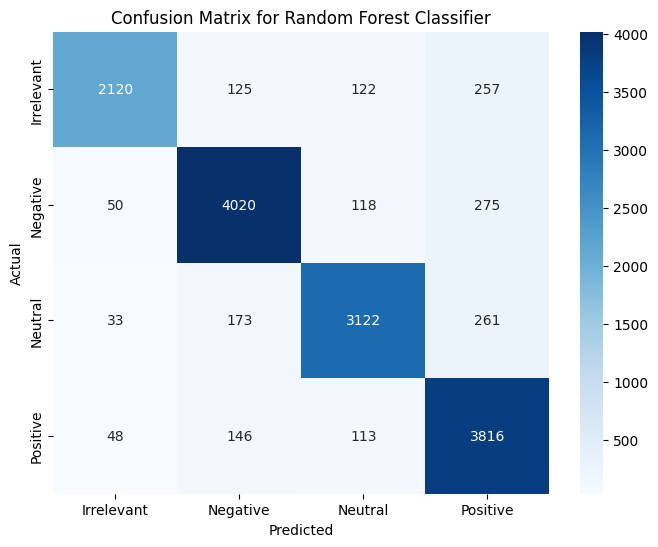

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

Preliminary conclusions based on this matrix:

- Good overall performance: The main diagonal has high values, indicating that the model is doing well overall.
- Greater confusion between close categories: There seems to be more confusion between “ close” categories such as Negative and Neutral, than between more distant categories such as Irrelevant and Positive. This might suggest that these categories are more difficult for the model to distinguish.

#### Aditional models:

In [ ]:
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

print("Logistic Regression - Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression - Accuracy: 0.6897087641056828
              precision    recall  f1-score   support

           0       0.70      0.53      0.60      2624
           1       0.73      0.77      0.75      4463
           2       0.63      0.66      0.65      3589
           3       0.70      0.73      0.71      4123

    accuracy                           0.69     14799
   macro avg       0.69      0.67      0.68     14799
weighted avg       0.69      0.69      0.69     14799



In [ ]:
svm = SVC(kernel='linear', random_state=42)

svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM - Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM - Accuracy: 0.7113994188796541
              precision    recall  f1-score   support

           0       0.70      0.60      0.65      2624
           1       0.75      0.78      0.77      4463
           2       0.66      0.68      0.67      3589
           3       0.72      0.74      0.73      4123

    accuracy                           0.71     14799
   macro avg       0.71      0.70      0.70     14799
weighted avg       0.71      0.71      0.71     14799



In [ ]:
nb = MultinomialNB()

nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes - Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes - Accuracy: 0.6415298330968309
              precision    recall  f1-score   support

           0       0.74      0.36      0.48      2624
           1       0.63      0.80      0.70      4463
           2       0.66      0.54      0.59      3589
           3       0.63      0.74      0.68      4123

    accuracy                           0.64     14799
   macro avg       0.66      0.61      0.61     14799
weighted avg       0.65      0.64      0.63     14799

